In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data/train_preprocessed.csv')
df.head()

,SK_ID_CURR,Tenure_Months,Avg_Monthly_Balance,Avg_Monthly_Utilization,Max_Monthly_Utilization,Pct_Txns_Fully_Paid,Months_Fully_Paid,Pct_Txns_Minimum_Paid,Months_Minimum_Paid,Payment_MinPayment_Ratio_mean,...,AMT_LESS_MAX,DAYS_LATE_AVG,DAYS_LATE_MAX,SK_DPD_DEF,LESS_GRANTED,REJECTED_APPLICATIONS,AMT_CREDIT_SUM_TOTAL,AMT_CREDIT_SUM_DEBT_TOTAL,AMT_CREDIT_SUM_LIMIT_TOTAL,AMT_CREDIT_SUM_OVERDUE_TOTAL
0,100011,74,54482.111149,0.302678,1.050000,0.554054,41,0.418919,31,0.502230,...,30833.685,4.807692,32.0,26.0,1,1,435228.300,0.000,0.00,0.0
1,100013,96,18159.919219,0.115301,1.024890,0.770833,74,0.000000,0,0.865673,...,23147.820,5.722581,38.0,0.0,1,0,2072280.060,0.000,0.00,0.0
2,100023,8,0.000000,0.000000,0.000000,1.000000,8,0.000000,0,0.000000,...,0.000,15.653846,43.0,0.0,1,0,1645692.345,137038.500,0.00,0.0
3,100028,49,8085.058163,0.035934,0.165937,0.244898,12,0.142857,7,0.000000,...,8505.000,3.265487,19.0,0.0,1,0,1520875.080,186304.500,101390.76,0.0
4,100036,12,0.000000,0.000000,0.000000,1.000000,12,0.000000,0,0.000000,...,0.000,18.500000,67.0,0.0,0,3,94959.000,8339.355,0.00,0.0


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


categoricals = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
cols_to_scale = [
    'Avg_Monthly_Balance','Months_Fully_Paid', 
    'Months_Minimum_Paid', 'Months_Minimum_Paid', 
    'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
    'Age_Years','Employed_Months', 'AMT_LESS_TOTAL',
    'AMT_LESS_MAX', 'DAYS_LATE_MAX', 'SK_DPD_DEF',
    'AMT_CREDIT_SUM_TOTAL', 'AMT_CREDIT_SUM_DEBT_TOTAL',
    'AMT_CREDIT_SUM_LIMIT_TOTAL', 'AMT_CREDIT_SUM_OVERDUE_TOTAL',
    'Tenure_Months', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
]
others = df.columns.difference(categoricals + cols_to_scale)

preproc = ColumnTransformer([
    ('cat', OneHotEncoder(), categoricals),
    ('scaled', MinMaxScaler(), cols_to_scale),
], remainder='passthrough')

In [ ]:
X = df.drop(columns='W_DEFAULT')
y = df['W_DEFAULT']

X = preproc.fit_transform(X)
X[np.isnan(X)] = 0  #naively fill NA with 0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy=0.3, random_state=1)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, auc, make_scorer

def auc_prc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_prc_score = make_scorer(auc_prc, needs_proba=True)

In [19]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    # 'scale_pos_weight': Real(1, 15),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.01, 10),
    'alpha': Real(0.01, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=4,
    cv=5,
    scoring='roc_auc'
)

opt.fit(X_train, y_train)

best_model = opt.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt.best_params_)

Best Hyperparameters: OrderedDict([('alpha', 10.0), ('colsample_bytree', 0.5352810774370599), ('eta', 0.09575270151624948), ('gamma', 1.0), ('lambda', 9.319532579733675), ('max_delta_step', 10.0), ('max_depth', 3), ('min_child_weight', 10.0), ('n_estimators', 250), ('subsample', 0.7946181664634562)])


In [20]:
best_model = XGBClassifier(**opt.best_params_)
best_model.fit(X_train, y_train)

results = {}

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

results['XGBoost'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

pd.DataFrame.from_dict(results, orient='index')

,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost,0.666667,0.019506,0.037903,0.759736,0.376986,0.106042


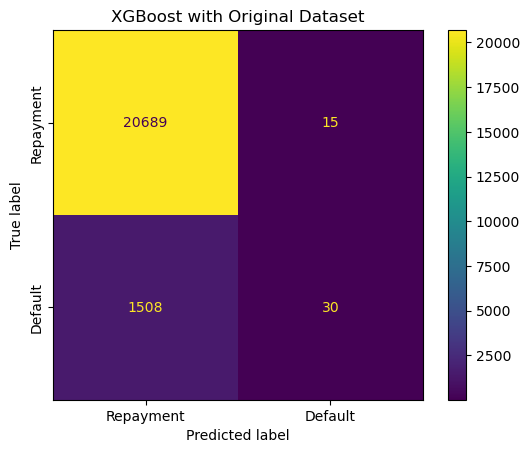

In [21]:
cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with Original Dataset');

In [17]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_space = {
    'n_estimators': Integer(50, 250),
    'max_depth': Integer(3, 10),
    'eta': Real(0.01, 0.5),
    'gamma': Real(0, 1),
    'min_child_weight': Real(1, 10),
    # 'scale_pos_weight': Real(1, 15),
    'max_delta_step': Real(1, 10),
    'colsample_bytree': Real(0.5, 1),
    'subsample': Real(0.5, 1),
    'lambda': Real(0.1, 10),
    'alpha': Real(0.1, 10),
}

model = XGBClassifier(objective='binary:logistic', eval_metric='auc')

opt_adasyn = BayesSearchCV(
    model,
    param_space,
    # random_state=0,
    n_jobs=4,
    cv=5,
    scoring='f1_macro'
)

opt_adasyn.fit(X_adasyn, y_adasyn)

best_model = opt_adasyn.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", opt_adasyn.best_params_)

Best Hyperparameters: OrderedDict([('alpha', 0.1533167596541245), ('colsample_bytree', 0.8244755186854076), ('eta', 0.1470828947322368), ('gamma', 0.0), ('lambda', 4.975569226291804), ('max_delta_step', 1.0), ('max_depth', 10), ('min_child_weight', 5.723664608261206), ('n_estimators', 156), ('subsample', 1.0)])


,Precision,Recall,F1,ROC AUC,PRC AUC,MCC
XGBoost + ADASYN,0.423913,0.025358,0.047853,0.736814,0.258333,0.090119


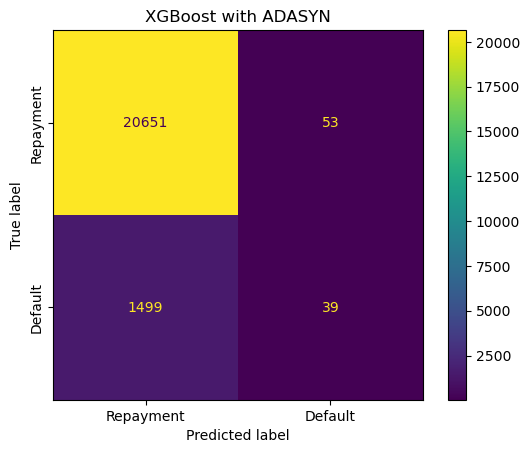

In [ ]:
best_model_adasyn = XGBClassifier(**opt_adasyn.best_params_)
best_model_adasyn.fit(X_adasyn, y_adasyn)

results = {}

y_pred = best_model_adasyn.predict(X_test)
y_proba = best_model_adasyn.predict_proba(X_test)

results['XGBoost + ADASYN'] = {
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba[:,1]),
    'PRC AUC': auc_prc(y_test, y_pred),
    'MCC': matthews_corrcoef(y_test, y_pred)
}

display(pd.DataFrame.from_dict(results, orient='index'))

cm = confusion_matrix(y_test, y_pred)

# fig = plt.subplots(figsize=(5,5))
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Repayment', 'Default'])
cm_display.plot()
plt.yticks(rotation=90, va='center')
plt.gca().set_title('XGBoost with ADASYN');

In [ ]:
test_df = pd.read_csv('data/test_preprocessed.csv')
X_submit = test_df.drop(columns='W_DEFAULT')
X_submit = preproc.transform(X_submit)
X_submit[np.isnan(X_submit)] = 0

y_submit_tuned = best_model.predict_proba(X_submit)
y_submit_tuned_adasyn = best_model_adasyn.predict_proba(X_submit)

pd.Series(y_submit_tuned[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb.csv')
pd.Series(y_submit_tuned_adasyn[:,1], index=test_df.SK_ID_CURR, name='TARGET').to_csv('submits/tuned_xgb_adasyn.csv')